# GDP analysis for Tunisia

## Imports 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
os.chdir('..')
from src.regressions import *
from src.helpers import *
from src.statistical_analysis import *
from src.evaluation_metrics import *
from src.feature_engineering import *
os.chdir('notebooks')

## Loading and visualizing the dataset 

Load the dataset in a pandas dataframe.

In [3]:
PATH = os.path.join("..", "data", "Tunisia2.csv")

dataset = pd.read_csv(PATH)

Visualize the dataset.

In [4]:
dataset

,YEAR,CGPD RELATIVE TO THE UNITED STATES (unit US=100),CONSUMPTION SHARE OF CGPD (unit %),CONSUMPTION SHARE OF RGDPL (unit %),CURRENT SAVINGS (unit %),EXCHANGE RATE (unit US=1),GOVERNMENT SHARE OF CGDP (unit %),GOVERNMENT SHARE OF RGDPL (unit %),INVESTMENT SHARE OF CGDP (unit %),INVESTMENT SHARE OF RGDPL (unit %),OPENNESS IN CONSTANT PRICES (unit %),OPENNESS IN CURRENT PRICES (unit %),POPULATION (unit 000S),PRICE LEVEL OF CONSUMPTION (unit PPP/XRATE),PRICE LEVEL OF GOVERNMENT (unit PPP/XRATE),PRICE LEVEL OF GROSS DOMESTIC PRODUCT (unit US=100),PRICE LEVEL OF INVESTMENT (unit PPP/XRATE),RATIO OF GNP TO GDP (CURRENT PRICES) (unit %),REAL GROSS DOMESTIC PRODUCT PER CAPITA (CURRENT PRICES) (unit $ CURRENT)
0,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot the GDP as a function of year.

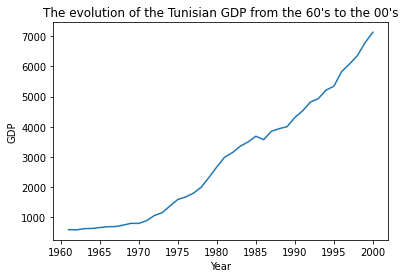

In [5]:
plt.plot(dataset["YEAR"], dataset["REAL GROSS DOMESTIC PRODUCT PER CAPITA (CURRENT PRICES) (unit $ CURRENT)"])
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("The evolution of the Tunisian GDP from the 60's to the 00's")
plt.show()

Split the dataset into a matrix `X` for the features and a vector `y` for the labels.

In [6]:
X, y = X_y_from_dataset(dataset)

print("We have", X.shape[0], "data points and", X.shape[1], "features")

We have 40 data points and 18 features


Verify whether there are highly correlated features.

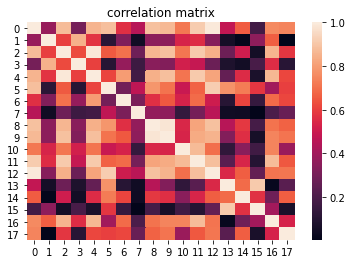

YEAR is highly correlated with:  CONSUMPTION SHARE OF CGPD (unit %), CURRENT SAVINGS (unit %), EXCHANGE RATE (unit US=1), INVESTMENT SHARE OF CGDP (unit %), INVESTMENT SHARE OF RGDPL (unit %), OPENNESS IN CURRENT PRICES (unit %), POPULATION (unit 000S) 

CGPD RELATIVE TO THE UNITED STATES (unit US=100) is highly correlated with:  CONSUMPTION SHARE OF RGDPL (unit %) 

CONSUMPTION SHARE OF CGPD (unit %) is highly correlated with:  YEAR, CURRENT SAVINGS (unit %), INVESTMENT SHARE OF CGDP (unit %), INVESTMENT SHARE OF RGDPL (unit %), OPENNESS IN CURRENT PRICES (unit %), POPULATION (unit 000S), PRICE LEVEL OF INVESTMENT (unit PPP/XRATE) 

CONSUMPTION SHARE OF RGDPL (unit %) is highly correlated with:  CGPD RELATIVE TO THE UNITED STATES (unit US=100) 

CURRENT SAVINGS (unit %) is highly correlated with:  YEAR, CONSUMPTION SHARE OF CGPD (unit %), INVESTMENT SHARE OF CGDP (unit %), INVESTMENT SHARE OF RGDPL (unit %), OPENNESS IN CURRENT PRICES (unit %), POPULATION (unit 000S), PRICE LEVEL OF I

In [7]:
correlation_matrix = np.abs(np.corrcoef(X, rowvar=False))

sns.heatmap(correlation_matrix)
plt.title("correlation matrix")
plt.show()

mask = correlation_matrix > 0.8
np.fill_diagonal(mask, False)
for i, m in enumerate(mask): 
    if (sum(m) != 0):
        print(dataset.columns[i], "is highly correlated with: ",
              ", ".join(dataset.columns[np.append(m, False)]), "\n")

Plot the population evolution through time. It's clear they're highly correlated features.

<AxesSubplot:xlabel='YEAR', ylabel='POPULATION (unit 000S)'>

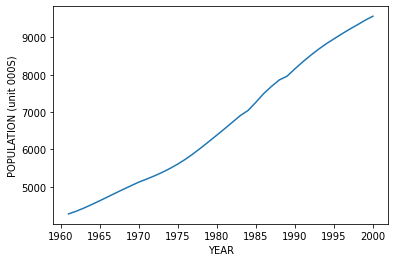

In [8]:
sns.lineplot(x="YEAR", y="POPULATION (unit 000S)", data=dataset)

In [9]:
print("The condition number is", condition_number(X))

The condition number is 721299.9786209331


In [10]:
VIF_X = VIF(X)
print("The VIF is:", VIF_X, "\n The column with the highest VIF is", dataset.columns[np.argmax(VIF_X)])

The VIF is: [1.11645535e+03 1.00383625e+01 1.85640902e+05 1.04041459e+02
 2.61782827e+05 1.09828808e+02 1.19242677e+04 5.62882948e+01
 9.63289494e+02 1.01722758e+03 1.84383514e+01 7.79283378e+01
 1.11149562e+03 3.97871957e+02 3.30620479e+01 7.80897523e+02
 2.36946099e+02 1.14280386e+01] 
 The column with the highest VIF is CURRENT SAVINGS (unit %)


The condition number, VIF and correlation matrix all tend to indicate that our data is kind off ill conditionned. We have to perform at least either some model selection, or filter out some predictors.

## The models

Split the data into 80% training and 20% testing sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Least Squares

Train with the least squares estimator.

1

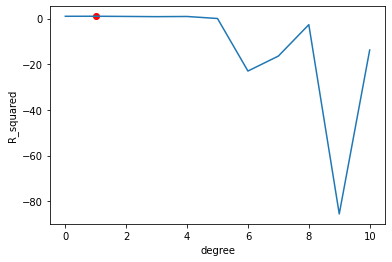

In [12]:
# Degree of zero means we leave the data set the way it is degree of 1 means we simply add a bias degree > 1
# We compute the polynomial expansion associated with that degree.
d = degree_cross_val(X_train, y_train, 10)
d

Augment the dataset.

In [13]:
# We split the dataset as instructed: the first 80% as train and the next 20% as test.
X_ls = build_poly(X, d)
X_train_ls, X_test_ls, _, _ = train_test_split(X_ls, y)

In [14]:
LS_w = least_squares(X_train_ls, y_train)

LS_prediction_data = predict(X_ls, LS_w)
LS_prediction_test = predict(X_test_ls, LS_w)

In [15]:
print("Testing R^2: ", R_squared(y_test, LS_prediction_test),
      "\nFull data R^2:", R_squared(y, LS_prediction_data))

Testing R^2:  0.2570474393185005 
Full data R^2: 0.9800708465799605


In [16]:
print("Full data adjusted R^2:", adjusted_R_squared(y, LS_prediction_data, X.shape[1]))

Full data adjusted R^2: 0.9629887150770694


Compute the CI for the coefficients.

In [17]:
X_for_var, w_for_var = (X_ls[:, 1:], LS_w[1:]) if d > 0 else (X, LS_w)
var = variance_least_squares_weights(X_for_var, y, LS_prediction_data)
lower_CI, upper_CI = confidence_interval(X_for_var.shape[0], X_for_var.shape[1], w_for_var, var)

Plot the coefficients with their CI intervals.

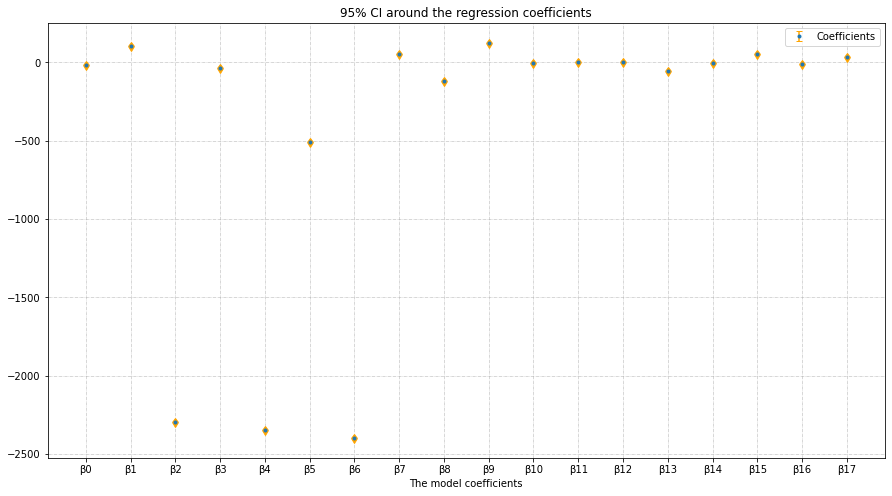

In [18]:
plt.figure(figsize=(15,8))
plt.errorbar(np.arange(X_for_var.shape[1]), w_for_var,
             yerr=np.vstack([np.squeeze(w_for_var-lower_CI), np.squeeze(upper_CI-w_for_var)]),
             fmt=".", ecolor='orange', lolims=True, uplims=True, label="Coefficients")
plt.xticks(np.arange(X.shape[1]), ["β"+str(i) for i in np.arange(X_for_var.shape[1])])
plt.title("95% CI around the regression coefficients")
plt.xlabel("The model coefficients")
plt.legend()
plt.grid(which='both', linestyle='-.', linewidth=0.5)
plt.show()

Compute the CI for the predictions.

In [19]:
var_ = variance_least_squares_line(X_for_var, y, LS_prediction_data)
lower_CI_line, upper_CI_line = confidence_interval(X_for_var.shape[0], X_for_var.shape[1], LS_prediction_data,
                                                   var_)

Plot the CI for the predictions.

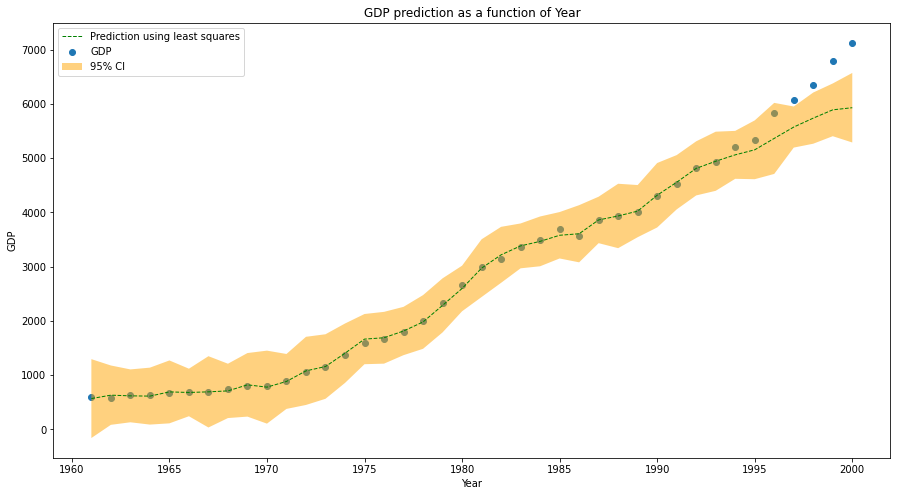

In [20]:
plt.figure(figsize=(15,8))
plt.scatter(X[:, 0], y, label="GDP")
plt.plot(X[:, 0], LS_prediction_data, color="g", lw=1, ls='--', label="Prediction using least squares")
plt.gca().fill_between(X[:, 0], np.squeeze(lower_CI_line), np.squeeze(upper_CI_line),
                       label="95% CI",
                       #color="#b9cfe7",
                       color="orange",
                       alpha=0.5,
                       edgecolor=None)
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("GDP prediction as a function of Year")
plt.legend()
plt.show()

### Ridge Regression

Train the ridge regression model.

In [21]:
lambda_r, d_r = cross_val_ridge(X_train, y_train, plot=False)
X_rr = build_poly(X, d_r)
X_train_rr, X_test_rr, _, _ = train_test_split(X_rr, y)
print("The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively:",
      lambda_r, d_r)

The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively: 0.91 1


In [22]:
Ridge_w = ridge_regression(X_train_rr, y_train, lambda_r)
Ridge_prediction_data = predict(X_rr, Ridge_w)
Ridge_prediction_test = predict(X_test_rr, Ridge_w)

In [23]:
print("Testing R^2: ", R_squared(y_test, Ridge_prediction_test),
      "\nFull data R^2:", R_squared(y, Ridge_prediction_data))

Testing R^2:  0.37691648123656707 
Full data R^2: 0.9831659698117066


In [24]:
print("Full data adjusted R^2:", adjusted_R_squared(y, Ridge_prediction_data, X_rr.shape[1]))

Full data adjusted R^2: 0.9671736411328278


In [25]:
X_for_var_rr, w_for_var_rr = (X_rr[:, 1:], Ridge_w[1:]) if d_r > 0 else (X, Ridge_w)
var = variance_least_squares_weights(X_for_var_rr, y, Ridge_prediction_data)
lower_CI_r, upper_CI_r = confidence_interval(X_for_var_rr.shape[0], X_for_var_rr.shape[1], w_for_var_rr, var)

Plot the coefficients with their CI intervals.

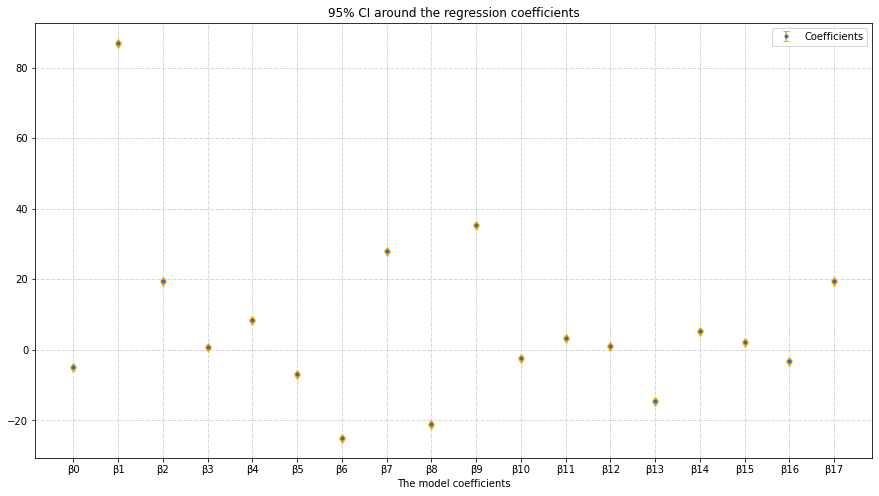

In [26]:
plt.figure(figsize=(15,8))

plt.errorbar(np.arange(X_for_var_rr.shape[1]), w_for_var_rr,
             yerr=np.vstack([np.squeeze(w_for_var_rr-lower_CI_r), np.squeeze(upper_CI_r-w_for_var_rr)]),
             fmt=".", ecolor='orange', lolims=True, uplims=True, label="Coefficients")

plt.xticks(np.arange(X_for_var_rr.shape[1]), ["β"+str(i) for i in np.arange(X_for_var_rr.shape[1])])

plt.title("95% CI around the regression coefficients")
plt.xlabel("The model coefficients")
plt.legend()
plt.grid(which='both', linestyle='-.', linewidth=0.5)
plt.show()

Compute the CI for the predictions.

In [27]:
var_ = variance_least_squares_line(X_for_var_rr, y, Ridge_prediction_data)
lower_CI_line_r, upper_CI_line_r = confidence_interval(X_for_var_rr.shape[0], X_for_var_rr.shape[1], Ridge_prediction_data, var_)

Plot the CI for the predictions.

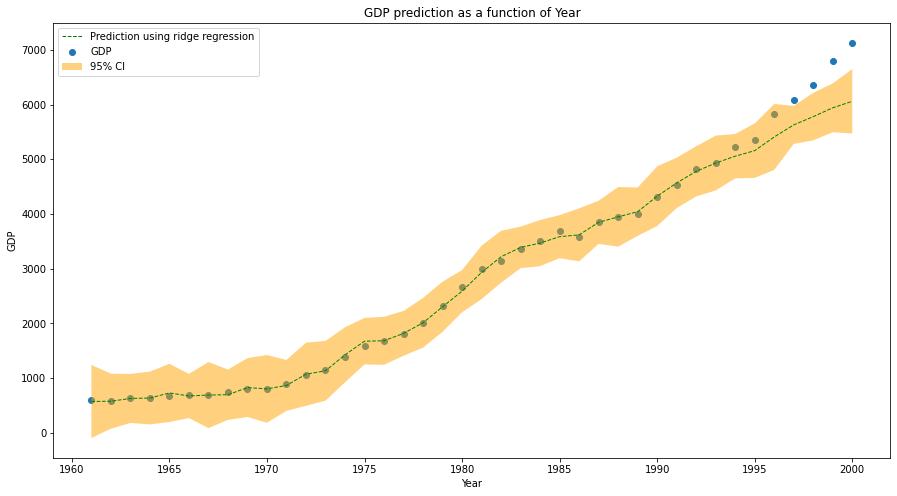

In [28]:
plt.figure(figsize=(15,8))
plt.scatter(X[:, 0], y, label="GDP")
plt.plot(X[:, 0], Ridge_prediction_data, color="g", lw=1, ls='--', label="Prediction using ridge regression")
plt.gca().fill_between(X[:, 0], np.squeeze(lower_CI_line_r), np.squeeze(upper_CI_line_r),
                       label="95% CI",
                       #color="#b9cfe7",
                       color="orange",
                       alpha=0.5,
                       edgecolor=None)
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("GDP prediction as a function of Year")
plt.legend()
plt.show()

### Subset selection

Find the optimal combination of features in terms of $r^2$.

In [29]:
scores, subsets = best_subset_ls(X_train, y_train)

In [30]:
i = np.argmax(scores)
sub = subsets[i]
variables = "\n\t- ".join(dataset.columns[list(sub)])
print("Best performance on the test: ", scores[i], "the subset is: ", sub)
print("This corresponds to the following variables:\n\t- " + variables)

Best performance on the test:  0.9997542085583582 the subset is:  (3, 5, 6, 12, 13, 14, 15, 16, 17)
This corresponds to the following variables:
	- CONSUMPTION SHARE OF RGDPL (unit %)
	- EXCHANGE RATE (unit US=1)
	- GOVERNMENT SHARE OF CGDP (unit %)
	- POPULATION (unit 000S)
	- PRICE LEVEL OF CONSUMPTION (unit PPP/XRATE)
	- PRICE LEVEL OF GOVERNMENT (unit PPP/XRATE)
	- PRICE LEVEL OF GROSS DOMESTIC PRODUCT (unit US=100)
	- PRICE LEVEL OF INVESTMENT (unit PPP/XRATE)
	- RATIO OF GNP TO GDP (CURRENT PRICES) (unit %)


In [31]:
X_ss = X[:, sub]
X_train_ss, X_test_ss, _, _ = train_test_split(X_ss, y)

Compute lest squares estimator using subset of features.

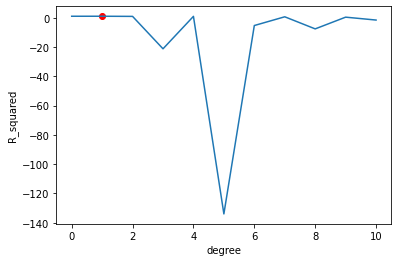

In [32]:
d_ss = degree_cross_val(X_train_ss, y_train, 10)
X_ls_ss = build_poly(X_ss, d_ss)
X_train_ls_ss, X_test_ls_ss, _, _ = train_test_split(X_ls_ss, y)

In [33]:
LS_w_ss = least_squares(X_train_ls_ss, y_train)

LS_ss_prediction_data = predict(X_ls_ss, LS_w_ss)
LS_ss_prediction_test = predict(X_test_ls_ss, LS_w_ss)

In [34]:
print("Testing R^2:  ", R_squared(y_test, LS_ss_prediction_test),
      "\nFull data R^2:", R_squared(y, LS_ss_prediction_data))

Testing R^2:   0.13905252989392514 
Full data R^2: 0.9761324267837447


In [35]:
print("Full data adjusted R^2:", adjusted_R_squared(y, LS_ss_prediction_data, X.shape[1]))

Full data adjusted R^2: 0.9556745068840973


In [36]:
lambda_r_ss, d_r_ss = cross_val_ridge(X_train_ss, y_train, plot=False)
print("The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively:",
      lambda_r_ss, d_r_ss)

The optimal hyper-parameters for the polynomial expansion and l2 regularization term are respectively: 0.74 2


In [37]:
X_r_ss = build_poly(X_ss, d_ss)
X_train_r_ss, X_test_r_ss, _, _ = train_test_split(X_r_ss, y)

In [38]:
Ridge_w_lambda_ss = ridge_regression(X_train_r_ss, y_train, lambda_r_ss)

Ridge_prediction_lambda_ss_data = predict(X_r_ss, Ridge_w_lambda_ss)
Ridge_prediction_lambda_ss_test = predict(X_test_r_ss, Ridge_w_lambda_ss)

In [39]:
print("Testing R^2: ", R_squared(y_test, Ridge_prediction_lambda_ss_test),
      "\nFull data R^2:", R_squared(y, Ridge_prediction_lambda_ss_data))

Testing R^2:  0.5750033856185083 
Full data R^2: 0.986889586488924


In [40]:
print("Full data adjusted R^2:", adjusted_R_squared(y, Ridge_prediction_lambda_ss_data, X.shape[1]))

Full data adjusted R^2: 0.975652089193716


In [41]:
idx = general_to_simple(X_train, y_train)

In [42]:
idx 


[0, 1, 2, 4, 7, 9, 12, 13]